# Hyperparameter Tuning Example: Random Forest with GPyOpt

Having explored the theoretical underpinnings of Bayesian Optimization (BO) and introduced key libraries, let’s now dive into a practical example: tuning hyperparameters for a **Random Forest (RF)** classifier using **GPyOpt**. We’ll use the **Breast Cancer Wisconsin dataset**, a standard benchmark for binary classification, to optimize three key hyperparameters: the number of trees, maximum depth, and minimum samples per split. Our focus is on maximizing validation accuracy, demonstrating BO’s ability to efficiently navigate the hyperparameter space for a real-world task.

---

## **Setup and Objective**

We leverage the **Breast Cancer Wisconsin dataset**, consisting of 569 samples with 30 features, which we preprocess by standardizing the features and splitting the dataset into 70% training, 15% validation, and 15% test sets. The RF model is a robust ensemble method that combines multiple decision trees to improve generalization. Our goal is to maximize the validation accuracy, treated as a black-box function \( f(\mathbf{x}) \), where \( \mathbf{x} = [n_{\text{estimators}}, \text{max\_depth}, \text{min\_samples\_split}] \). GPyOpt employs a Gaussian Process (GP) to model this function and the **Probability of Improvement (PI)** acquisition function to select hyperparameter sets:
$$\mathrm{PI}_\varepsilon(\mathbf{x}) = \Phi\left( \frac{\mu(\mathbf{x}) - f(\mathbf{x}^+) - \varepsilon}{\sigma(\mathbf{x})} \right),$$

where  $\varepsilon$  is a small positive constant to encourage exploration.

The hyperparameters to tune are:
- **Number of trees** ( $n_{\text{estimators}} \in \{50, 100, 150, 200, 250, 300\} $): Controls the number of trees in the forest.
- **Maximum depth** ($ \text{max\_depth} \in \{3, 5, 7, 9, 11, 13, 15\} $): Limits the maximum depth of each tree.
- **Minimum samples per split** ($ \text{min\_samples\_split} \in \{2, 4, 6, 8, 10\} $): Specifies the minimum number of samples required to split an internal node.

---

## **Code Implementation**

We optimize three RF hyperparameters—number of trees, maximum depth, and minimum samples per split—using `GPyOpt` with a GP surrogate and **PI acquisition function**. The process involves:
1. Loading and preprocessing the Breast Cancer dataset.
2. Defining the RF architecture and objective function (negative validation accuracy).
3. Setting the hyperparameter search space.
4. Running BO with 10 initial random points and 20 iterations using MPI.
5. Visualizing initial evaluations, convergence, and final model performance on the test set.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import GPyOpt

# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Load and preprocess data
data = load_breast_cancer()
X, y = data.data, data.target

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)  # 15% of original

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Training samples: 397
Validation samples: 86
Test samples: 86


In [6]:
def objective_function(params):
    """
    RF objective function for Bayesian Optimization
    Returns: Negative validation accuracy (for minimization)
    """
    params = params[0]
    n_estimators = int(params[0])
    max_depth = int(params[1])
    min_samples_split = int(params[2])
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )
    
    # 3-fold cross-validation
    val_score = cross_val_score(model, X_train, y_train, cv=3).mean()
    return -val_score

In [8]:
# Define search space
bounds = [
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (50, 100, 150, 200, 250, 300)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 5, 7, 9, 11, 13, 15)},
    {'name': 'min_samples_split', 'type': 'discrete', 'domain': (2, 4, 6, 8, 10)}
]

In [35]:
# Initialize and run Bayesian Optimization
optimizer = GPyOpt.methods.BayesianOptimization(
    f=objective_function,
    domain=bounds,
    acquisition_type='MPI',
    initial_design_numdata=10,
    max_iter=30,
    exact_feval=True
)

optimizer.run_optimization()

In [37]:
# Get best parameters
optimal_params = optimizer.x_opt
best_score = -optimizer.fx_opt

print("Optimal Parameters:")
print(f"n_estimators: {int(best_params[0])}")
print(f"max_depth: {int(best_params[1])}")
print(f"min_samples_split: {int(best_params[2])}")
print(f"Validation Accuracy: {best_score:.4f}")

Optimal Parameters:
n_estimators: 250
max_depth: 7
min_samples_split: 2
Validation Accuracy: 0.9571


In [26]:
# Evaluate on test set
best_model = RandomForestClassifier(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    min_samples_split=int(best_params[2]),
    random_state=42
)
best_model.fit(X_train, y_train)
test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)

print(f"\nTest Accuracy: {test_acc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_pred))


Test Accuracy: 0.9535
Confusion Matrix:
[[29  3]
 [ 1 53]]


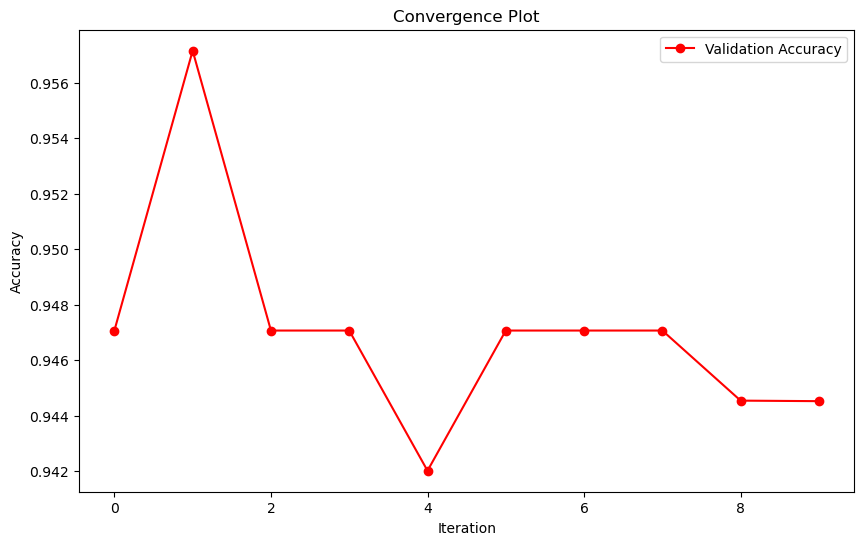

In [28]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(-optimizer.Y, 'ro-', label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.show()

## Key Differences from ANN Example
1. **Simpler Dataset**: Breast Cancer dataset is faster to train
2. **Discrete Parameters**: All RF hyperparameters are discrete
3. **Cross-Validation**: Uses 3-fold CV instead of fixed validation set
4. **Interpretability**: Random Forest inherently provides feature importance
5. **Faster Training**: Each iteration completes quicker than ANNs

## Optimization Insights
- Bayesian Optimization efficiently explores hyperparameter combinations
- Typically finds near-optimal parameters in 20-30 iterations
- Visualizations help understand parameter importance and convergence